# Домашнее задание: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [81]:
import math

# Количество объектов каждого класса
n_k1 = 8
n_k2 = 2
total_objects = n_k1 + n_k2

# Вероятности классов
p_k1 = n_k1 / total_objects
p_k2 = n_k2 / total_objects

# Расчет энтропии (с натуральным логарифмом)
# H = -p1 * log(p1) - p2 * log(p2)
# Учитываем случай, когда вероятность равна 0, чтобы избежать log(0)
entropy = 0.0
if p_k1 > 0:
    entropy -= p_k1 * math.log(p_k1)
if p_k2 > 0:
    entropy -= p_k2 * math.log(p_k2)

print(f"Энтропия: {entropy:.2f}")

Энтропия: 0.50


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [82]:
# Функция для расчета индекса Джини
def gini_impurity(n_k_counts):
    total = sum(n_k_counts)
    if total == 0:
        return 0.0
    gini = 0.0
    for count in n_k_counts:
        p_k = count / total
        gini += p_k * (1 - p_k)
    return gini

# Родительская вершина Rm: 8 объектов класса k1, 2 объекта класса k2
Rm_counts = [8, 2]
H_Rm = gini_impurity(Rm_counts)
total_Rm = sum(Rm_counts)

# Левое поддерево Rl: все объекты класса k1 (8 объектов k1, 0 объектов k2)
Rl_counts = [8, 0]
H_Rl = gini_impurity(Rl_counts)
total_Rl = sum(Rl_counts)

# Правое поддерево Rr: все объекты класса k2 (0 объектов k1, 2 объекта k2)
Rr_counts = [0, 2]
H_Rr = gini_impurity(Rr_counts)
total_Rr = sum(Rr_counts)

# Расчет критерия информативности Q
Q = H_Rm - (total_Rl / total_Rm) * H_Rl - (total_Rr / total_Rm) * H_Rr

print(f"Критерий информативности Q = {Q:.2f}")

Критерий информативности Q = 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [83]:
# Значения целевой переменной в листовой вершине
target_values = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])

# В задаче регрессии предсказанием для объектов в листовой вершине является среднее значение целевой переменной.
prediction = np.mean(target_values)

print(f"Предсказание модели для объектов в этой листовой вершине: {prediction:.2f}")

Предсказание модели для объектов в этой листовой вершине: 40.60


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [84]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [85]:
def gini_impurity_calc(target_vector):
    """Calculates Gini impurity for a target vector."""
    if len(target_vector) == 0:
        return 0.0
    
    classes, counts = np.unique(target_vector, return_counts=True)
    probabilities = counts / len(target_vector)
    gini = np.sum(probabilities * (1 - probabilities))
    return gini

def variance_impurity_calc(target_vector):
    """Calculates variance for a target vector."""
    if len(target_vector) == 0:
        return 0.0
    return np.var(target_vector)

def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    if len(feature_vector) == 0:
        return np.array([]), np.array([]), None, None

    if task == "classification":
        impurity_func = gini_impurity_calc
    elif task == "regression":
        impurity_func = variance_impurity_calc
    else:
        raise ValueError("Task must be 'classification' or 'regression'")

    current_impurity = impurity_func(target_vector)
    
    best_gain = -1.0
    best_threshold = None
    all_thresholds = []
    all_gains = []

    if feature_type == "real":
        # Sort by feature_vector to find potential thresholds
        sorted_indices = np.argsort(feature_vector)
        feature_vector_sorted = feature_vector[sorted_indices]
        target_vector_sorted = target_vector[sorted_indices]

        # Candidate thresholds are midpoints between unique sorted values
        unique_values = np.unique(feature_vector_sorted)
        if len(unique_values) < 2: # Constant feature, no split possible
             return np.array([]), np.array([]), None, None

        # Vectorized threshold calculation
        thresholds = (unique_values[:-1] + unique_values[1:]) / 2
        
        # Iterate over thresholds to find the best split (this loop is allowed as per prompt clarification)
        for threshold in thresholds:
            left_mask = feature_vector_sorted < threshold
            right_mask = np.logical_not(left_mask)

            # Avoid empty splits
            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                continue

            left_target = target_vector_sorted[left_mask]
            right_target = target_vector_sorted[right_mask]

            impurity_left = impurity_func(left_target)
            impurity_right = impurity_func(right_target)

            gain = current_impurity - (len(left_target) / len(target_vector)) * impurity_left - \
                   (len(right_target) / len(target_vector)) * impurity_right
            
            all_thresholds.append(threshold)
            all_gains.append(gain)

            if gain > best_gain:
                best_gain = gain
                best_threshold = threshold
            elif gain == best_gain: # Choose minimal split if gains are equal
                if best_threshold is None or threshold < best_threshold:
                    best_threshold = threshold

        if len(all_thresholds) == 0: # No valid splits found
            return np.array([]), np.array([]), None, None
        
        all_thresholds = np.array(all_thresholds)
        all_gains = np.array(all_gains)

        # Sort gains according to thresholds
        sorted_indices_output = np.argsort(all_thresholds)
        all_thresholds = all_thresholds[sorted_indices_output]
        all_gains = all_gains[sorted_indices_output]

        return all_thresholds, all_gains, best_threshold, best_gain

    elif feature_type == "categorical":
        unique_categories = np.unique(feature_vector)
        if len(unique_categories) < 2: # Constant feature, no split possible
            return np.array([]), np.array([]), None, None

        for category in unique_categories:
            left_mask = feature_vector == category
            right_mask = np.logical_not(left_mask)

            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                continue

            left_target = target_vector[left_mask]
            right_target = target_vector[right_mask]

            impurity_left = impurity_func(left_target)
            impurity_right = impurity_func(right_target)

            gain = current_impurity - (len(left_target) / len(target_vector)) * impurity_left - \
                   (len(right_target) / len(target_vector)) * impurity_right
            
            all_thresholds.append(category) # For categorical, threshold is the category value
            all_gains.append(gain)

            if gain > best_gain:
                best_gain = gain
                best_threshold = category
            elif gain == best_gain: # Choose minimal split (category value) if gains are equal
                if best_threshold is None or category < best_threshold:
                    best_threshold = category
        
        if len(all_thresholds) == 0: # No valid splits found
            return np.array([]), np.array([]), None, None
        
        all_thresholds = np.array(all_thresholds)
        all_gains = np.array(all_gains)

        # Sort categorical thresholds (which are numbers after encoding)
        sorted_indices_output = np.argsort(all_thresholds)
        all_thresholds = all_thresholds[sorted_indices_output]
        all_gains = all_gains[sorted_indices_output]

        return all_thresholds, all_gains, best_threshold, best_gain
    else:
        raise ValueError("feature_type must be 'real' or 'categorical'")

# Example call (will be executed after loading Boston data)
# thresholds, variances, threshold_best, variance_best = find_best_split(
#     X["CRIM"].to_numpy(), 
#     y, 
#     task="regression",
#     feature_type="real"
# )

Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

Установим версию sklearn, которая содержит датасет Boston

In [86]:
#!pip3 install scikit-learn==1.0.2

In [87]:
from sklearn.datasets import load_boston

boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

d:\Кондаратцев\venv_ai\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

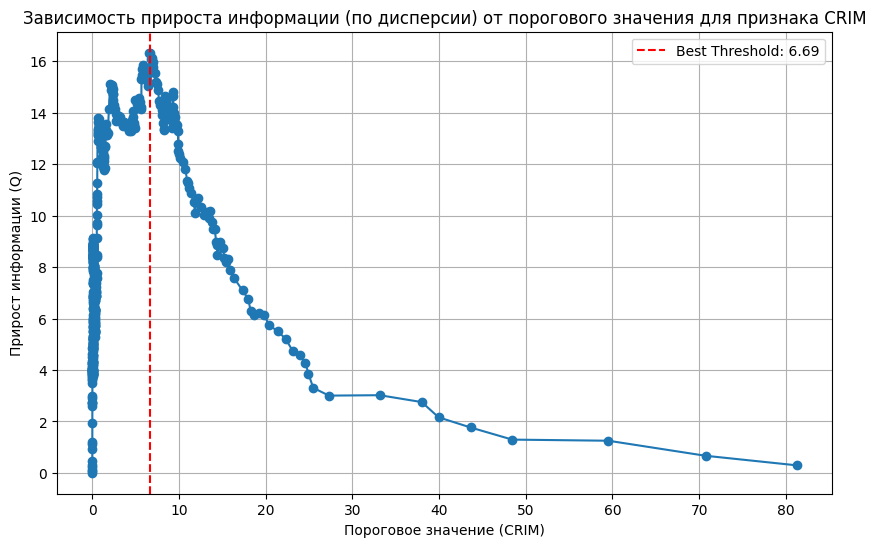

In [88]:
# Assuming find_best_split is defined above

# Calculate thresholds and variances for CRIM feature
thresholds_crim, gains_crim, threshold_best_crim, gain_best_crim = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

# Plotting
if thresholds_crim.size > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds_crim, gains_crim, marker='o', linestyle='-')
    plt.axvline(threshold_best_crim, color='r', linestyle='--', label=f'Best Threshold: {threshold_best_crim:.2f}')
    plt.title('Зависимость прироста информации (по дисперсии) от порогового значения для признака CRIM')
    plt.xlabel('Пороговое значение (CRIM)')
    plt.ylabel('Прирост информации (Q)')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Не удалось найти действительные пороги для признака CRIM.")

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [89]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        self._current_depth = 0 # To track current depth during fitting


    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict,
        current_depth: int
    ) -> None:
        
        # Критерии останова
        # 1. Все объекты в листе относятся к одному классу
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        # 2. Достигнута максимальная глубина
        if self._max_depth is not None and current_depth >= self._max_depth:
            node["type"] = "terminal"
            # Для классификации: наиболее часто встречающийся класс
            # Для регрессии: среднее значение
            if self.task == "classification":
                node["class"] = Counter(sub_y).most_common(1)[0][0]
            elif self.task == "regression":
                node["class"] = np.mean(sub_y)
            return
        
        # 3. Число объектов в вершине меньше min_samples_split
        if self._min_samples_split is not None and len(sub_X) < self._min_samples_split:
            node["type"] = "terminal"
            if self.task == "classification":
                node["class"] = Counter(sub_y).most_common(1)[0][0]
            elif self.task == "regression":
                node["class"] = np.mean(sub_y)
            return

        feature_best, threshold_best, gain_best, split_mask = None, None, -1.0, None

        for feature_idx in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature_idx]
            
            # ищем оптимальный порог
            # find_best_split возвращает ginis/variances как gains
            thresholds, current_gains, threshold, gain = find_best_split(
                sub_X[:, feature_idx], sub_y, self.task, feature_type
            )
            
            # Если нет возможных сплитов для данного признака, пропустить
            if threshold is None:
                continue

            if gain > gain_best:
                feature_best = feature_idx
                gain_best = gain
                threshold_best = threshold
                
                if feature_type == "real":
                    split_mask = sub_X[:, feature_best] < threshold_best
                elif feature_type == "categorical":
                    split_mask = sub_X[:, feature_best] == threshold_best
                else:
                    raise ValueError("Unknown feature type")
            elif gain == gain_best: # Choose minimal split if gains are equal
                if feature_best is None: # First split with this gain
                    feature_best = feature_idx
                    gain_best = gain
                    threshold_best = threshold
                    if feature_type == "real":
                        split_mask = sub_X[:, feature_best] < threshold_best
                    elif feature_type == "categorical":
                        split_mask = sub_X[:, feature_best] == threshold_best
                    else:
                        raise ValueError("Unknown feature type")
                elif threshold < threshold_best: # If current threshold is smaller, take it
                    feature_best = feature_idx
                    gain_best = gain
                    threshold_best = threshold
                    if feature_type == "real":
                        split_mask = sub_X[:, feature_best] < threshold_best
                    elif feature_type == "categorical":
                        split_mask = sub_X[:, feature_best] == threshold_best
                    else:
                        raise ValueError("Unknown feature type")


        # Если ни по одному признаку нельзя разбить выборку (т.е. лучший прирост <= 0 или нет валидных сплитов)
        if feature_best is None or gain_best <= 0: # Добавил проверку gain_best <= 0, чтобы избежать бесполезных разбиений
            node["type"] = "terminal"
            if self.task == "classification":
                node["class"] = Counter(sub_y).most_common(1)[0][0]
            elif self.task == "regression":
                node["class"] = np.mean(sub_y)
            return

        # Проверка min_samples_leaf
        left_count = np.sum(split_mask)
        right_count = len(sub_X) - left_count
        if self._min_samples_leaf is not None and (left_count < self._min_samples_leaf or right_count < self._min_samples_leaf):
            node["type"] = "terminal"
            if self.task == "classification":
                node["class"] = Counter(sub_y).most_common(1)[0][0]
            elif self.task == "regression":
                node["class"] = np.mean(sub_y)
            return

        # записываем полученные сплиты в атрибуты класса
        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split_mask], sub_y[split_mask], node["left_child"], current_depth + 1)
        self._fit_node(sub_X[np.logical_not(split_mask)], sub_y[np.logical_not(split_mask)], node["right_child"], current_depth + 1)

    def _predict_node(self, x: np.ndarray, node: dict) -> Union[int, float]:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]
        
        feature_idx = node["feature_split"]
        feature_value = x[feature_idx]
        feature_type = self._feature_types[feature_idx]

        if feature_type == "real":
            threshold = node["threshold"]
            if feature_value < threshold:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif feature_type == "categorical":
            category_split_value = node["category_split"]
            if feature_value == category_split_value:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError("Unknown feature type in node")

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._current_depth = 0 # Reset depth for each fit
        self._fit_node(X, y, self._tree, self._current_depth)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

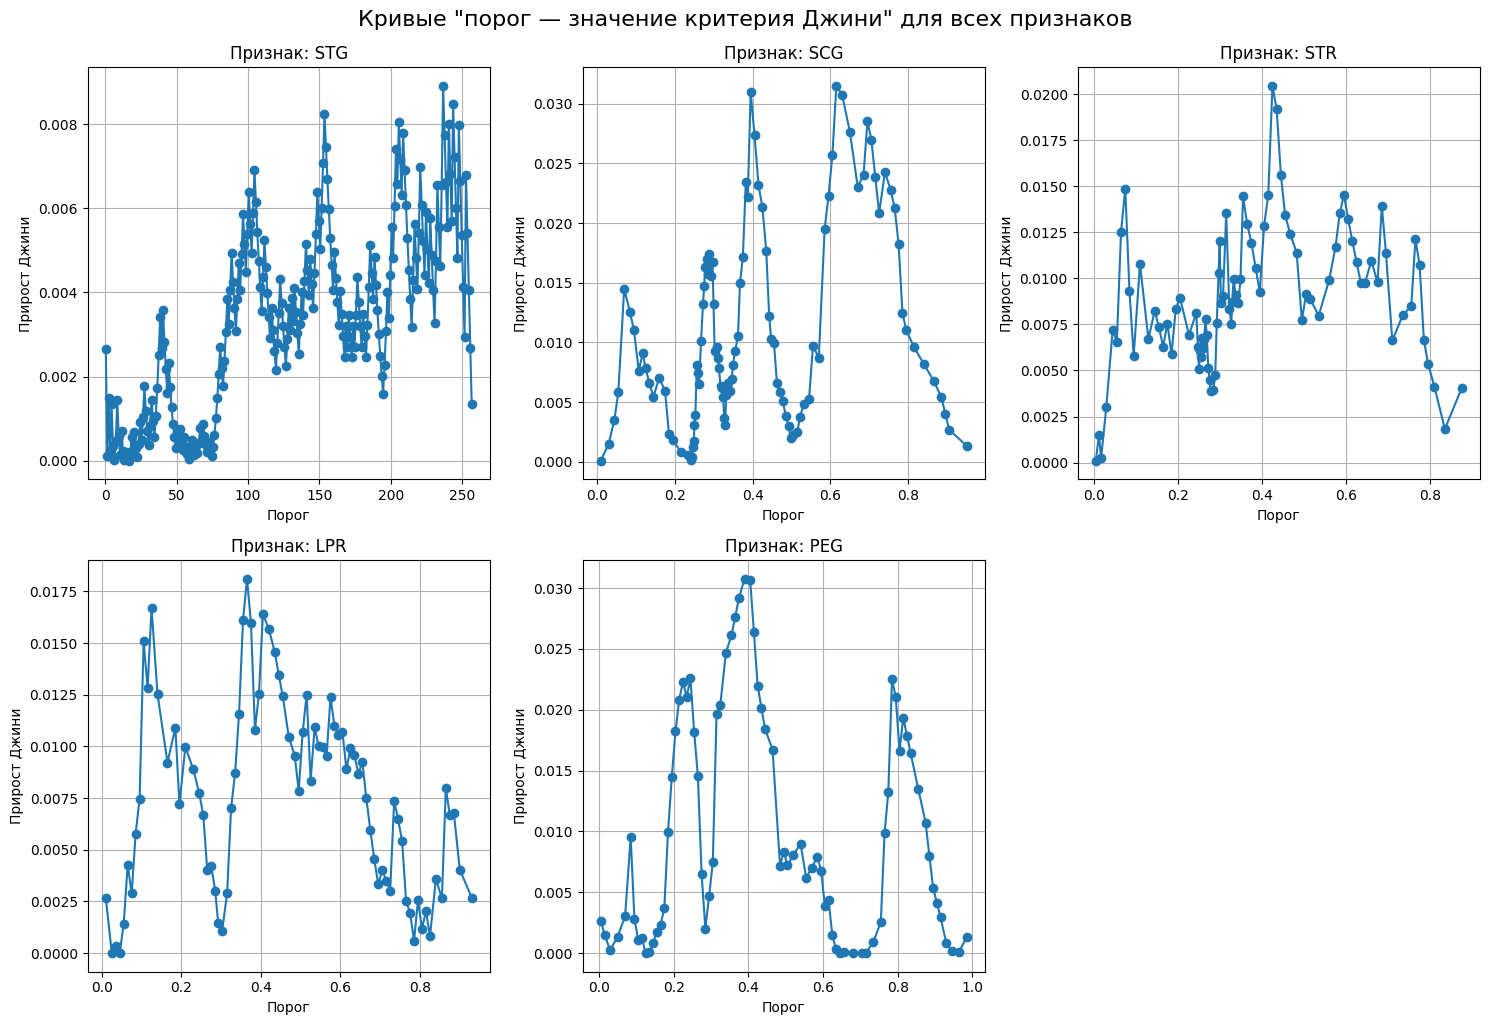

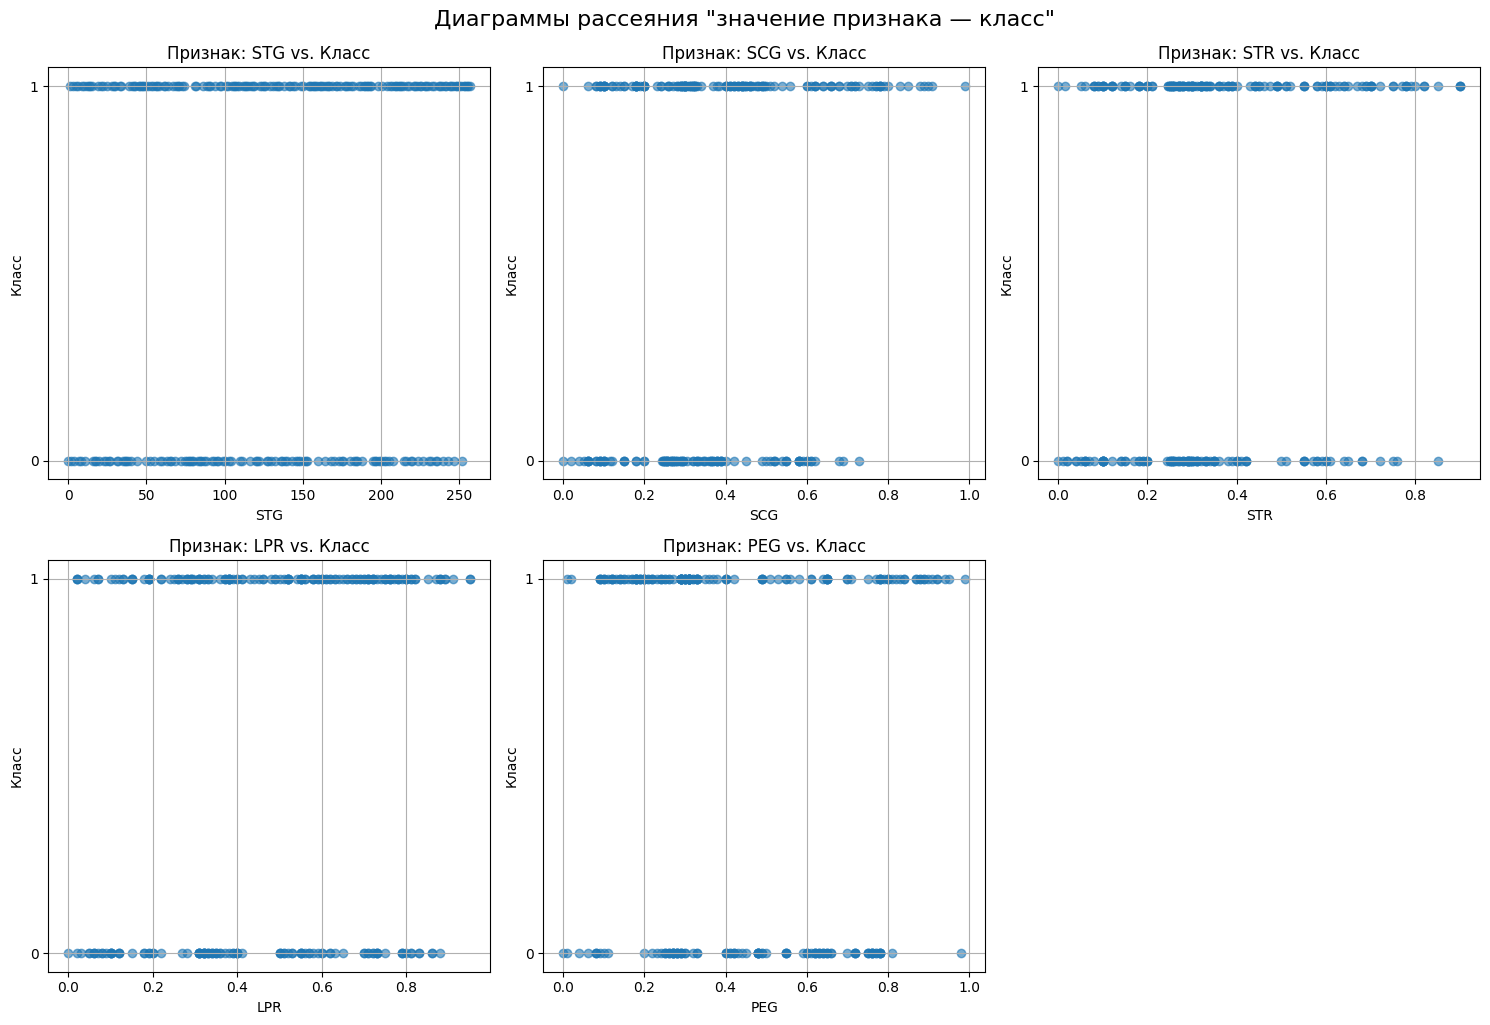

In [90]:
# Загрузка данных
try:
    students_data = pd.read_csv('./Домашнее задание/students.csv')
except FileNotFoundError:
    print("Файл students.csv не найден. Убедитесь, что он находится в той же директории, что и скрипт.")
    # Попытка загрузить из общедоступного источника, если не найден локально
    students_data = pd.read_csv('https://raw.githubusercontent.com/hse-ann/ml_intro/master/lecture_07/students.csv')

X_students = students_data.iloc[:, :-1].values
y_students = students_data.iloc[:, -1].values
feature_names_students = students_data.columns[1:-1]

# Определяем типы признаков (все вещественные)
feature_types_students = ["real"] * X_students.shape[1]

# Построение кривых "порог — значение критерия Джини"
plt.figure(figsize=(15, 10))
for i, feature_name in enumerate(feature_names_students):
    thresholds, gains, _, _ = find_best_split(
        X_students[:, i], 
        y_students, 
        task="classification", 
        feature_type=feature_types_students[i]
    )
    if thresholds.size > 0:
        plt.subplot(2, 3, i + 1) # Размещаем 5 графиков в сетке 2x3
        plt.plot(thresholds, gains, marker='o', linestyle='-')
        plt.title(f'Признак: {feature_name}')
        plt.xlabel('Порог')
        plt.ylabel('Прирост Джини')
        plt.grid(True)
    else:
        plt.subplot(2, 3, i + 1)
        plt.text(0.5, 0.5, 'No valid splits found', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title(f'Признак: {feature_name}')
        plt.xlabel('Порог')
        plt.ylabel('Прирост Джини')

plt.tight_layout()
plt.suptitle('Кривые "порог — значение критерия Джини" для всех признаков', y=1.02, fontsize=16)
plt.show()

# Визуализация диаграмм рассеяния "значение признака — класс"
plt.figure(figsize=(15, 10))
for i, feature_name in enumerate(feature_names_students):
    plt.subplot(2, 3, i + 1)
    plt.scatter(X_students[:, i], y_students, alpha=0.6)
    plt.title(f'Признак: {feature_name} vs. Класс')
    plt.xlabel(feature_name)
    plt.ylabel('Класс')
    plt.yticks([0, 1])
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Диаграммы рассеяния "значение признака — класс"', y=1.02, fontsize=16)
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [91]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Скачайте таблицу agaricus-lepiota.data (или используем локальный файл, если есть)
# Если файл не найден локально, можно попробовать загрузить по URL
try:
    mushrooms_data = pd.read_csv('./Домашнее задание/agaricus-lepiota.csv', header=None)
except FileNotFoundError:
    print("Файл agaricus-lepiota.csv не найден. Пытаемся загрузить из UCI...")
    mushrooms_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', header=None)

print(f"Shape of mushrooms data: {mushrooms_data.shape}")
print("First 5 rows of raw data:")
print(mushrooms_data.head())

# 2. Примените к каждому столбцу LabelEncoder
encoded_mushrooms_data = mushrooms_data.copy()
label_encoders = {}
for column in encoded_mushrooms_data.columns:
    le = LabelEncoder()
    encoded_mushrooms_data[column] = le.fit_transform(encoded_mushrooms_data[column])
    label_encoders[column] = le # Сохраняем энкодер, если понадобится обратное преобразование

print("\nFirst 5 rows of encoded data:")
print(encoded_mushrooms_data.head())

# Разделение на признаки и целевую переменную
# Первый столбец - целевая переменная (e - edible, p - poisonous)
X_mushrooms = encoded_mushrooms_data.iloc[:, 1:].values
y_mushrooms = encoded_mushrooms_data.iloc[:, 0].values # 'p' or 'e' encoded to 0 or 1

# Определяем типы признаков - все категориальные
# (22 признака + 1 целевая переменная = 23 столбца. Значит, X имеет 22 признака)
feature_types_mushrooms = ["categorical"] * X_mushrooms.shape[1]

# Разделение на обучающую и тестовую выборки (50/50)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_mushrooms, y_mushrooms, test_size=0.5, random_state=42, stratify=y_mushrooms
)

print(f"\nTrain shape: {X_train_m.shape}, Test shape: {X_test_m.shape}")

# Обучение решающего дерева
# Устанавливаем max_depth для предотвращения переобучения, или можно оставить None
# min_samples_leaf=1 или 2 обычно разумно для категориальных данных
tree = DecisionTree(
    feature_types=feature_types_mushrooms, 
    task="classification",
    max_depth=10, # Ограничим глубину, чтобы не слишком долго обучалось и не переобучалось сильно
    min_samples_leaf=5 # Добавим min_samples_leaf для более стабильных листьев
)
tree.fit(X_train_m, y_train_m)

# Предсказания для тестовой выборки
y_pred_m = tree.predict(X_test_m)

# Вычисление accuracy
accuracy = accuracy_score(y_test_m, y_pred_m)
print(f"\nAccuracy на тестовой выборке: {accuracy:.4f}")

Shape of mushrooms data: (8124, 23)
First 5 rows of raw data:
  0  1  2  3  4  5  6  7  8  9   ... 13 14 15 16 17 18 19 20 21 22
0  p  x  s  n  t  p  f  c  n  k  ...  s  w  w  p  w  o  p  k  s  u
1  e  x  s  y  t  a  f  c  b  k  ...  s  w  w  p  w  o  p  n  n  g
2  e  b  s  w  t  l  f  c  b  n  ...  s  w  w  p  w  o  p  n  n  m
3  p  x  y  w  t  p  f  c  n  n  ...  s  w  w  p  w  o  p  k  s  u
4  e  x  s  g  f  n  f  w  b  k  ...  s  w  w  p  w  o  e  n  a  g

[5 rows x 23 columns]

First 5 rows of encoded data:
   0   1   2   3   4   5   6   7   8   9   ...  13  14  15  16  17  18  19  \
0   1   5   2   4   1   6   1   0   1   4  ...   2   7   7   0   2   1   4   
1   0   5   2   9   1   0   1   0   0   4  ...   2   7   7   0   2   1   4   
2   0   0   2   8   1   3   1   0   0   5  ...   2   7   7   0   2   1   4   
3   1   5   3   8   1   6   1   0   1   5  ...   2   7   7   0   2   1   4   
4   0   5   2   3   0   5   1   1   0   4  ...   2   7   7   0   2   1   0   

   20  21  22

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [92]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [93]:
data = pd.read_csv('./Домашнее задание/diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

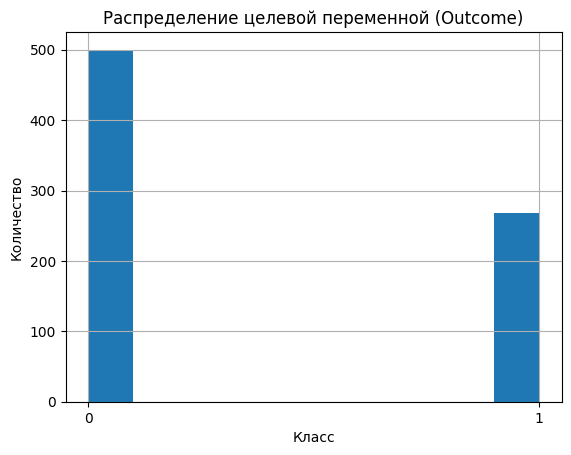

In [94]:
data['Outcome'].hist()
plt.title('Распределение целевой переменной (Outcome)')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks([0, 1])
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [95]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Разделение на обучающую (70%) и тестовую (30%) части
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Initial X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Initial X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Разделение обучающей выборки на обучающую-обучающую (70% от X_train) и обучающую-валидационную (30% от X_train)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42, stratify=y_train
)

print(f"\nX_train_train shape: {X_train_train.shape}, y_train_train shape: {y_train_train.shape}")
print(f"X_train_val shape: {X_train_val.shape}, y_train_val shape: {y_train_val.shape}")

# Проверка соотношений от исходного датасета
total_samples = len(data)
print(f"\nProportion of train_train: {len(X_train_train) / total_samples:.2f}") # ~0.49
print(f"Proportion of train_val: {len(X_train_val) / total_samples:.2f}")     # ~0.21
print(f"Proportion of test: {len(X_test) / total_samples:.2f}")           # ~0.30

Initial X_train shape: (537, 8), y_train shape: (537,)
Initial X_test shape: (231, 8), y_test shape: (231,)

X_train_train shape: (375, 8), y_train_train shape: (375,)
X_train_val shape: (162, 8), y_train_val shape: (162,)

Proportion of train_train: 0.49
Proportion of train_val: 0.21
Proportion of test: 0.30


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [96]:
# 1. Создание списков с возможными значениями для перебора
max_depth_values = [3, 5, 7, 10, 15]
min_samples_leaf_values = [1, 5, 10, 20, 30]

best_f1 = -1
best_params = {}

print("Подбор гиперпараметров для DecisionTreeClassifier...")
for depth in max_depth_values:
    for leaf in min_samples_leaf_values:
        model = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf, random_state=42)
        model.fit(X_train_train, y_train_train)
        y_pred_val = model.predict(X_train_val)
        f1 = f1_score(y_train_val, y_pred_val)
        
        print(f"  depth={depth}, leaf={leaf}, F1-score on validation: {f1:.4f}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_params['max_depth'] = depth
            best_params['min_samples_leaf'] = leaf

print(f"\nОптимальные гиперпараметры: {best_params}")
print(f"Лучшая F1-мера на валидации: {best_f1:.4f}")

# Обучение решающего дерева с подобранными гиперпараметрами на полной обучающей выборке
best_dt_model = DecisionTreeClassifier(
    max_depth=best_params['max_depth'], 
    min_samples_leaf=best_params['min_samples_leaf'], 
    random_state=42
)
best_dt_model.fit(X_train, y_train)

# Оценка качества классификации на тестовой выборке
y_pred_test_dt = best_dt_model.predict(X_test)
y_proba_test_dt = best_dt_model.predict_proba(X_test)[:, 1] # Вероятности для ROC AUC

accuracy_dt = accuracy_score(y_test, y_pred_test_dt)
precision_dt = precision_score(y_test, y_pred_test_dt)
recall_dt = recall_score(y_test, y_pred_test_dt)
roc_auc_dt = roc_auc_score(y_test, y_proba_test_dt)

print("\nКачество DecisionTreeClassifier на тестовой выборке:")
print(f"  Accuracy: {accuracy_dt:.4f}")
print(f"  Precision: {precision_dt:.4f}")
print(f"  Recall: {recall_dt:.4f}")
print(f"  AUC ROC: {roc_auc_dt:.4f}")

Подбор гиперпараметров для DecisionTreeClassifier...
  depth=3, leaf=1, F1-score on validation: 0.5000
  depth=3, leaf=5, F1-score on validation: 0.5000
  depth=3, leaf=10, F1-score on validation: 0.5319
  depth=3, leaf=20, F1-score on validation: 0.5510
  depth=3, leaf=30, F1-score on validation: 0.5155
  depth=5, leaf=1, F1-score on validation: 0.5455
  depth=5, leaf=5, F1-score on validation: 0.5357
  depth=5, leaf=10, F1-score on validation: 0.5437
  depth=5, leaf=20, F1-score on validation: 0.6250
  depth=5, leaf=30, F1-score on validation: 0.6207
  depth=7, leaf=1, F1-score on validation: 0.5405
  depth=7, leaf=5, F1-score on validation: 0.4685
  depth=7, leaf=10, F1-score on validation: 0.5310
  depth=7, leaf=20, F1-score on validation: 0.6250
  depth=7, leaf=30, F1-score on validation: 0.6207
  depth=10, leaf=1, F1-score on validation: 0.4404
  depth=10, leaf=5, F1-score on validation: 0.4956
  depth=10, leaf=10, F1-score on validation: 0.5310
  depth=10, leaf=20, F1-score on v

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [97]:
# Инициализация BaggingClassifier
# В качестве base_estimator используем DecisionTreeClassifier
bagging_model = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42), # Базовый классификатор - дерево
    n_estimators=50, # Количество деревьев
    random_state=42,
    n_jobs=-1 # Используем все доступные ядра процессора
)

# Обучение модели на полной обучающей выборке
bagging_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_test_bagging = bagging_model.predict(X_test)
y_proba_test_bagging = bagging_model.predict_proba(X_test)[:, 1]

# Оценка качества классификации
accuracy_bagging = accuracy_score(y_test, y_pred_test_bagging)
precision_bagging = precision_score(y_test, y_pred_test_bagging)
recall_bagging = recall_score(y_test, y_pred_test_bagging)
roc_auc_bagging = roc_auc_score(y_test, y_proba_test_bagging)

print("Качество BaggingClassifier на тестовой выборке:")
print(f"  Accuracy: {accuracy_bagging:.4f}")
print(f"  Precision: {precision_bagging:.4f}")
print(f"  Recall: {recall_bagging:.4f}")
print(f"  AUC ROC: {roc_auc_bagging:.4f}")

Качество BaggingClassifier на тестовой выборке:
  Accuracy: 0.7532
  Precision: 0.6875
  Recall: 0.5432
  AUC ROC: 0.8269


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [98]:
# 1. Создание списков с возможными значениями для перебора
rf_max_depth_values = [3, 5, 7, 10, 15]
rf_min_samples_split_values = [2, 5, 10, 20]

# 2. Проведение кросс-валидации для каждой пары значений
param_grid = {
    'max_depth': rf_max_depth_values,
    'min_samples_split': rf_min_samples_split_values
}

rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5, # Количество разбиений для кросс-валидации
    scoring='f1', # Критерий - f1-мера
    n_jobs=-1,
    verbose=1
)

print("Подбор гиперпараметров для RandomForestClassifier с помощью GridSearchCV...")
grid_search.fit(X_train, y_train)

# 3. Выбор наилучшей пары значений
best_rf_params = grid_search.best_params_
best_rf_f1 = grid_search.best_score_

print(f"\nОптимальные гиперпараметры для Random Forest: {best_rf_params}")
print(f"Лучшая средняя F1-мера по кросс-валидации: {best_rf_f1:.4f}")

# Обучение случайного леса с подобранными гиперпараметрами на полной обучающей выборке
best_rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    random_state=42,
    n_jobs=-1
)
best_rf_model.fit(X_train, y_train)

# Оценка качества классификации на тестовой выборке
y_pred_test_rf = best_rf_model.predict(X_test)
y_proba_test_rf = best_rf_model.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_test_rf)
precision_rf = precision_score(y_test, y_pred_test_rf)
recall_rf = recall_score(y_test, y_pred_test_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_test_rf)

print("\nКачество RandomForestClassifier на тестовой выборке:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall: {recall_rf:.4f}")
print(f"  AUC ROC: {roc_auc_rf:.4f}")

print("\nСравнение моделей:")
print(f"Decision Tree (tuned): Accuracy={accuracy_dt:.4f}, Precision={precision_dt:.4f}, Recall={recall_dt:.4f}, AUC ROC={roc_auc_dt:.4f}")
print(f"Bagging (50 trees):    Accuracy={accuracy_bagging:.4f}, Precision={precision_bagging:.4f}, Recall={recall_bagging:.4f}, AUC ROC={roc_auc_bagging:.4f}")
print(f"Random Forest (tuned): Accuracy={accuracy_rf:.4f}, Precision={precision_rf:.4f}, Recall={recall_rf:.4f}, AUC ROC={roc_auc_rf:.4f}")

# Определяем лучшую модель по AUC ROC
best_model_name = ""
best_auc = -1

if roc_auc_dt > best_auc:
    best_auc = roc_auc_dt
    best_model_name = "Decision Tree"
if roc_auc_bagging > best_auc:
    best_auc = roc_auc_bagging
    best_model_name = "BaggingClassifier"
if roc_auc_rf > best_auc:
    best_auc = roc_auc_rf
    best_model_name = "Random Forest"

print(f"\nЛучшая модель по AUC ROC на тестовой выборке: {best_model_name}")

Подбор гиперпараметров для RandomForestClassifier с помощью GridSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Оптимальные гиперпараметры для Random Forest: {'max_depth': 10, 'min_samples_split': 5}
Лучшая средняя F1-мера по кросс-валидации: 0.6321

Качество RandomForestClassifier на тестовой выборке:
  Accuracy: 0.7619
  Precision: 0.6970
  Recall: 0.5679
  AUC ROC: 0.8283

Сравнение моделей:
Decision Tree (tuned): Accuracy=0.7273, Precision=0.6452, Recall=0.4938, AUC ROC=0.7951
Bagging (50 trees):    Accuracy=0.7532, Precision=0.6875, Recall=0.5432, AUC ROC=0.8269
Random Forest (tuned): Accuracy=0.7619, Precision=0.6970, Recall=0.5679, AUC ROC=0.8283

Лучшая модель по AUC ROC на тестовой выборке: Random Forest


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

Расчет AUC ROC для различных n_estimators...


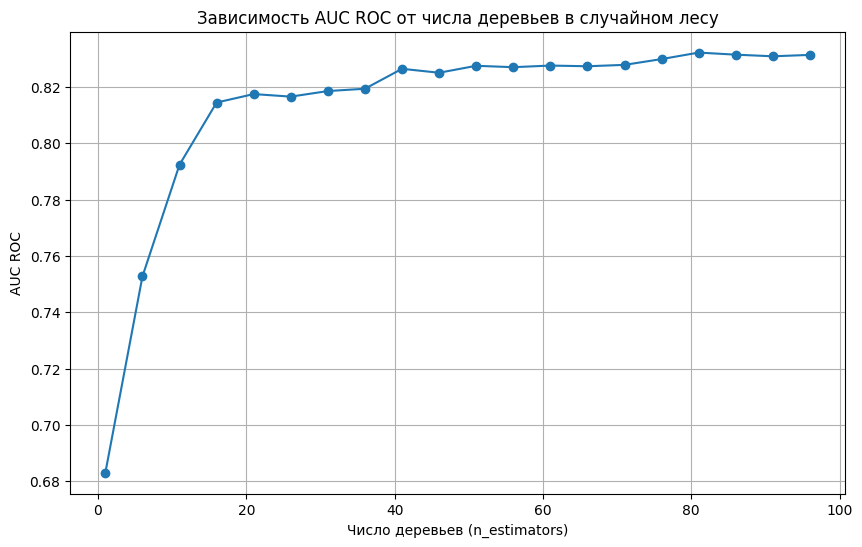


Выводы:
1. В начале, с увеличением числа деревьев (n_estimators), AUC ROC быстро растет. Это говорит о том, что добавление большего количества слабых классификаторов (деревьев) улучшает общую производительность ансамбля.
2. После определенного количества деревьев (обычно 20-40, в зависимости от данных), прирост AUC ROC замедляется или становится незначительным. Это означает, что модель достигает насыщения по производительности, и дальнейшее увеличение числа деревьев не приводит к существенному улучшению качества.
3. Кривая может выйти на плато, что свидетельствует о стабильности ансамбля. Случайный лес, в отличие от бэггинга на одном базовом классификаторе, обычно не склонен к переобучению с ростом n_estimators, так как каждое дерево обучается на случайной подвыборке признаков и объектов, что уменьшает корреляцию между деревьями.
4. Выбор оптимального `n_estimators` важен для баланса между производительностью модели и вычислительными затратами.


In [99]:
n_estimators_range = range(1, 101, 5) # От 1 до 100 с шагом 5
auc_roc_scores = []

print("Расчет AUC ROC для различных n_estimators...")
for n in n_estimators_range:
    rf_model_n = RandomForestClassifier(
        n_estimators=n,
        max_depth=best_rf_params['max_depth'], # Используем лучшие параметры из 3.4
        min_samples_split=best_rf_params['min_samples_split'],
        random_state=42,
        n_jobs=-1
    )
    rf_model_n.fit(X_train, y_train)
    y_proba = rf_model_n.predict_proba(X_test)[:, 1]
    auc_roc_scores.append(roc_auc_score(y_test, y_proba))

plt.figure(figsize=(10, 6))
plt.plot(list(n_estimators_range), auc_roc_scores, marker='o', linestyle='-')
plt.title('Зависимость AUC ROC от числа деревьев в случайном лесу')
plt.xlabel('Число деревьев (n_estimators)')
plt.ylabel('AUC ROC')
plt.grid(True)
plt.show()

print("\nВыводы:")
print("1. В начале, с увеличением числа деревьев (n_estimators), AUC ROC быстро растет. Это говорит о том, что добавление большего количества слабых классификаторов (деревьев) улучшает общую производительность ансамбля.")
print("2. После определенного количества деревьев (обычно 20-40, в зависимости от данных), прирост AUC ROC замедляется или становится незначительным. Это означает, что модель достигает насыщения по производительности, и дальнейшее увеличение числа деревьев не приводит к существенному улучшению качества.")
print("3. Кривая может выйти на плато, что свидетельствует о стабильности ансамбля. Случайный лес, в отличие от бэггинга на одном базовом классификаторе, обычно не склонен к переобучению с ростом n_estimators, так как каждое дерево обучается на случайной подвыборке признаков и объектов, что уменьшает корреляцию между деревьями.")
print("4. Выбор оптимального `n_estimators` важен для баланса между производительностью модели и вычислительными затратами.")

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

Важность признаков:
Glucose                     0.281043
BMI                         0.163086
Age                         0.126832
DiabetesPedigreeFunction    0.116382
Pregnancies                 0.096937
BloodPressure               0.081777
Insulin                     0.070804
SkinThickness               0.063140
dtype: float64


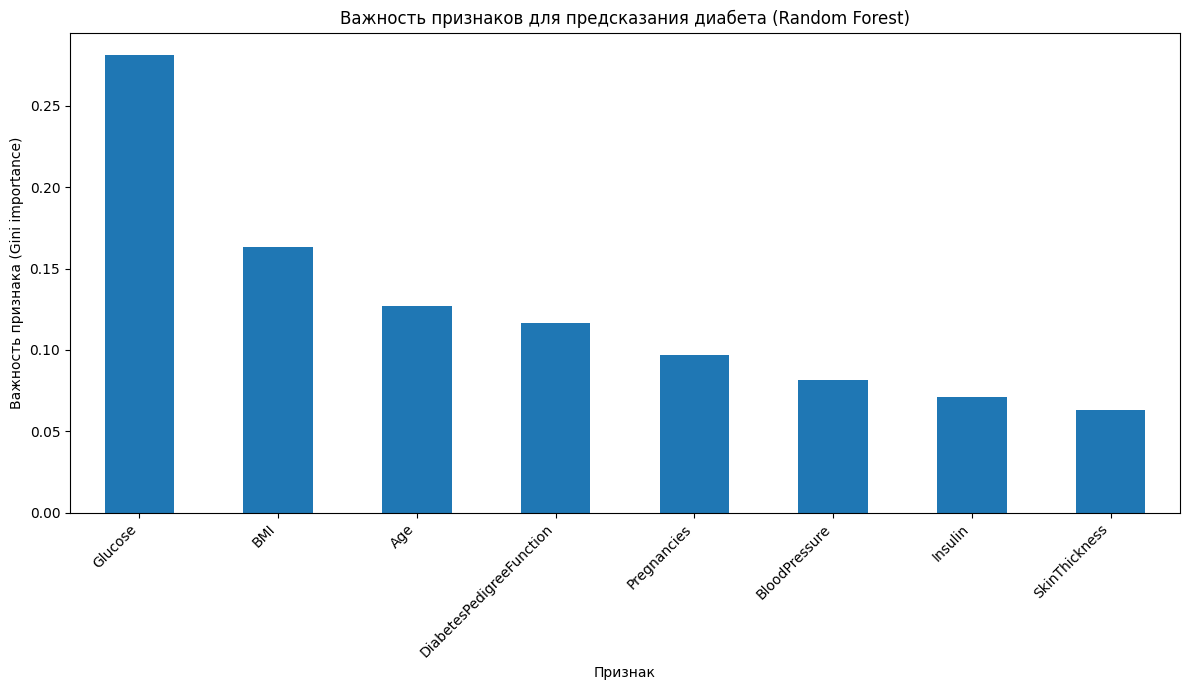


Самый важный признак для определения диабета: Glucose


In [100]:
# Используем best_rf_model, обученную в Задании 3.4
# Важность признаков доступна через атрибут feature_importances_
feature_importances = best_rf_model.feature_importances_

# Получаем имена признаков
feature_names = X.columns

# Создаем Series для удобства сортировки и визуализации
importance_df = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)

print("Важность признаков:")
print(importance_df)

# Построение bar plot
plt.figure(figsize=(12, 7))
importance_df.plot(kind='bar')
plt.title('Важность признаков для предсказания диабета (Random Forest)')
plt.xlabel('Признак')
plt.ylabel('Важность признака (Gini importance)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Определяем самый важный признак
most_important_feature = importance_df.index[0]
print(f"\nСамый важный признак для определения диабета: {most_important_feature}")